In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import matplotlib as mpl
from matplotlib.colors import ListedColormap ,LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
import mpl_toolkits.mplot3d as a3
from scipy.spatial import KDTree
%xmode Plain

Exception reporting mode: Plain


In [2]:
def positive(arg):
    return(arg+abs(arg))/2

def z_rotation(angle):
    Z = np.array([[np.cos(angle),-np.sin(angle),0],
                  [np.sin(angle),np.cos(angle),0],[0,0,1]])
    return Z

def sph_to_cart(phi,theta): #for r = 1
    return np.array([np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)])

def cart_to_sph(x,y,z):
    return np.array([np.arctan2(y,x),np.arctan2(np.sqrt(x**2+y**2),z)])

def proj_2d(v1,v2,r): #vector r is projected onto the plane spun by v1 and v2
    return np.dot(v1,r)/np.linalg.norm(v1)*v1 + np.dot(v2,r)/np.linalg.norm(v2)*v2

def fmt(x, pos): #for good ticks on the colorbar
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${}\times10^{{{}}}$'.format(a, b)

def fresnel_s(theta_i): #van space naar water
    return abs((np.cos(theta_i)-1.33*np.sqrt(1-(1/1.33*np.sin(theta_i))**2))/(np.cos(theta_i)+(1.33*np.sqrt(1-(1/1.33*np.sin(theta_i))**2))))**2

def fresnel_p(theta_i):
    return abs((1.33*np.cos(theta_i)-np.sqrt(1-(1/1.33*np.sin(theta_i))**2))/(1.33*np.cos(theta_i)+(np.sqrt(1-(1/1.33*np.sin(theta_i))**2))))**2
    
models = ('lambert','LomSee','spec','water')


The model used is spec


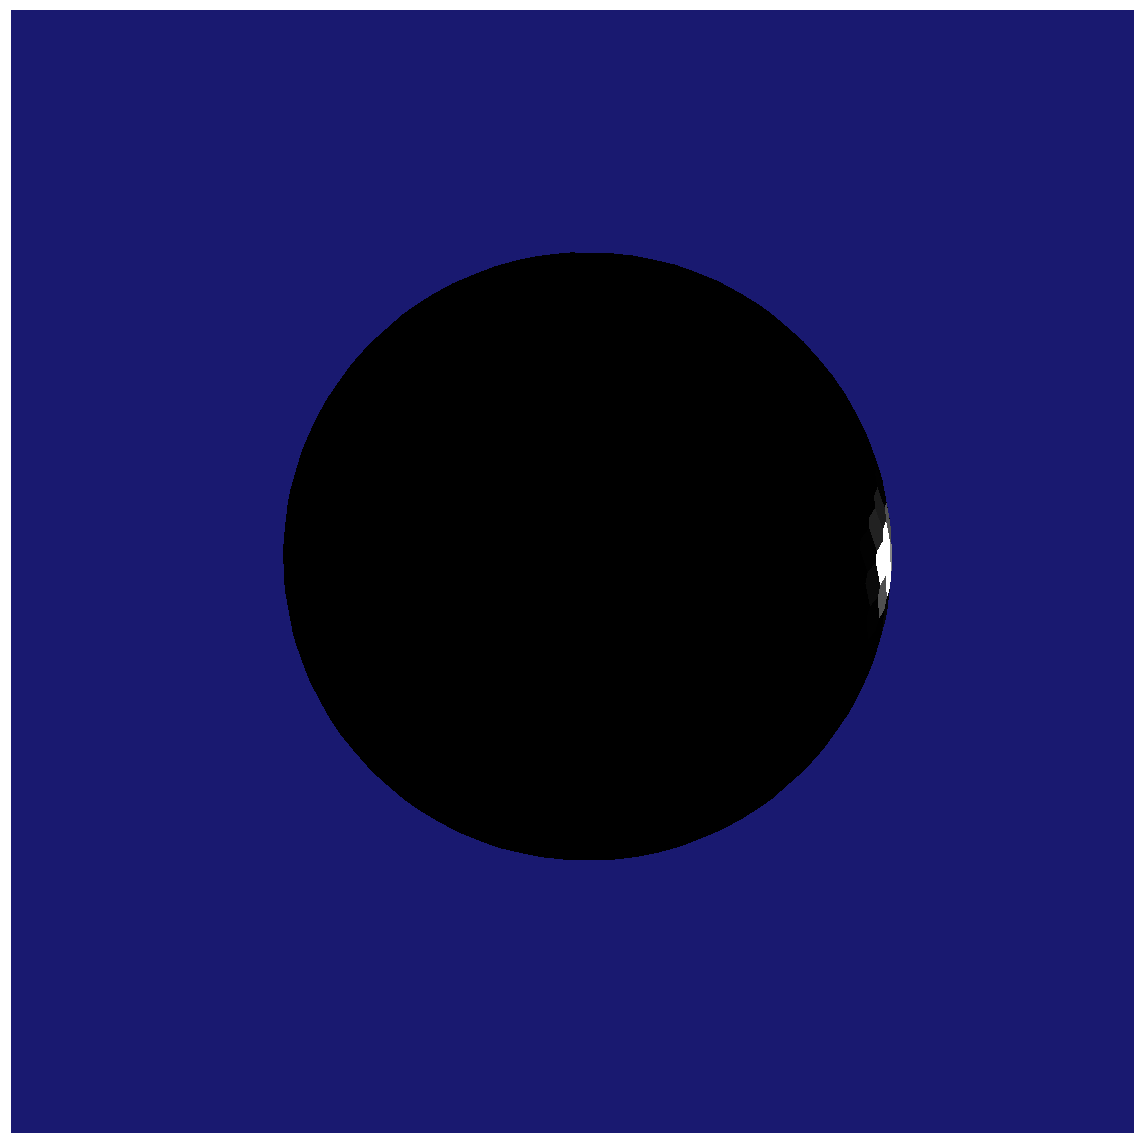

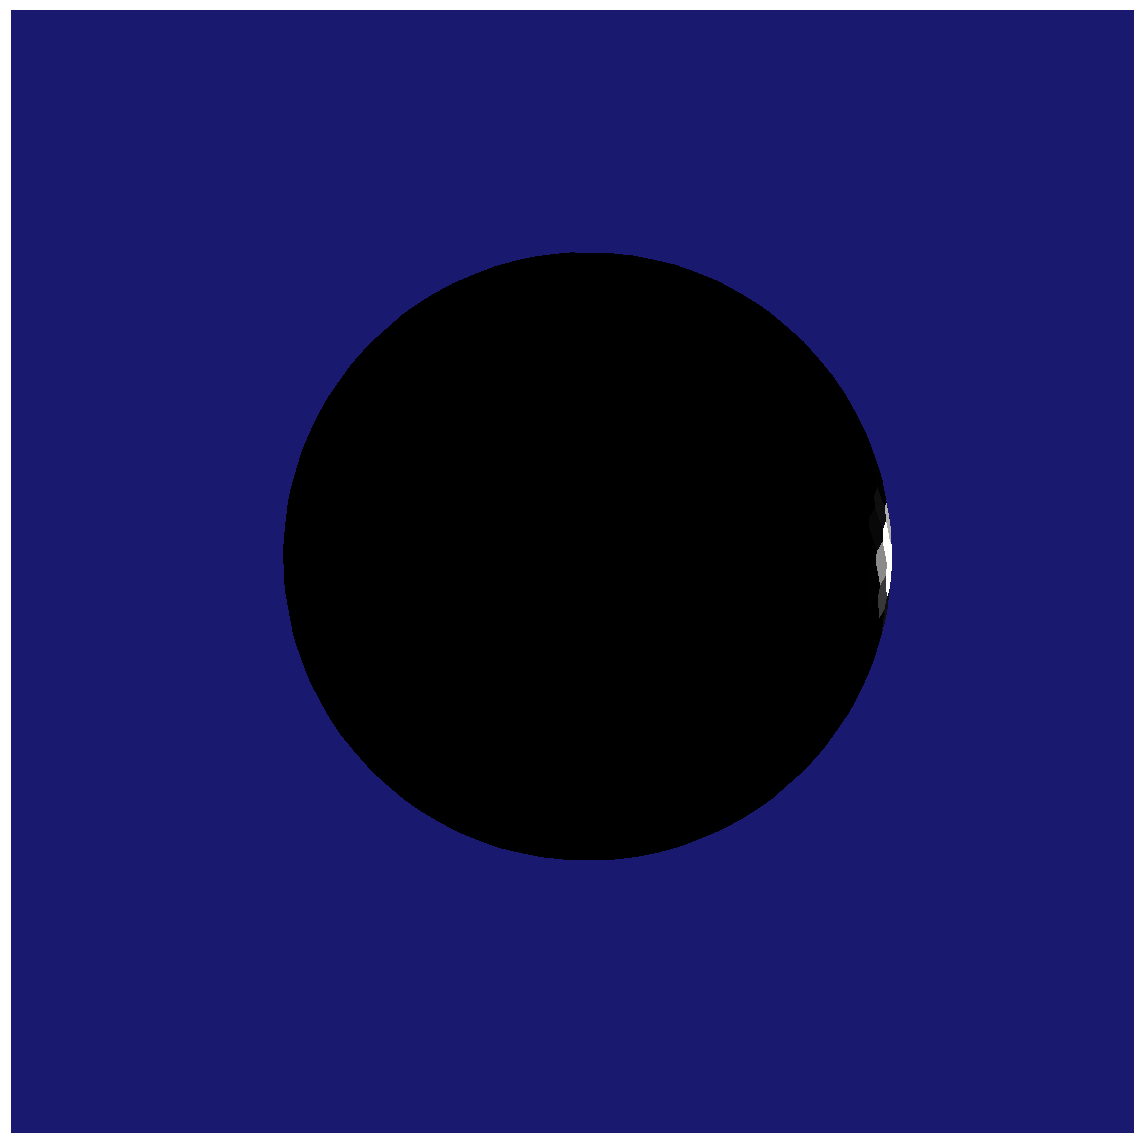

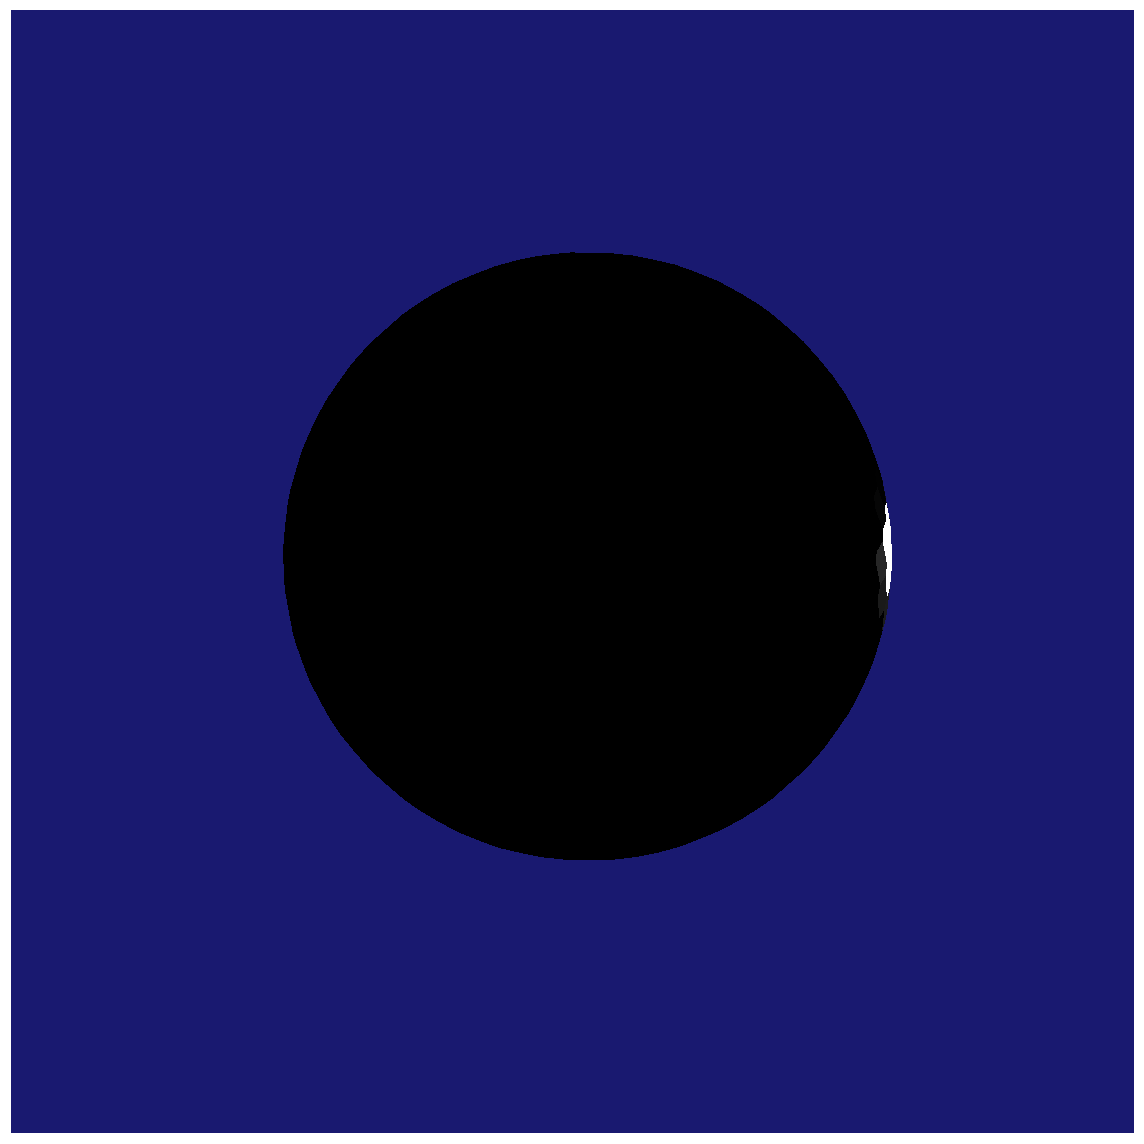

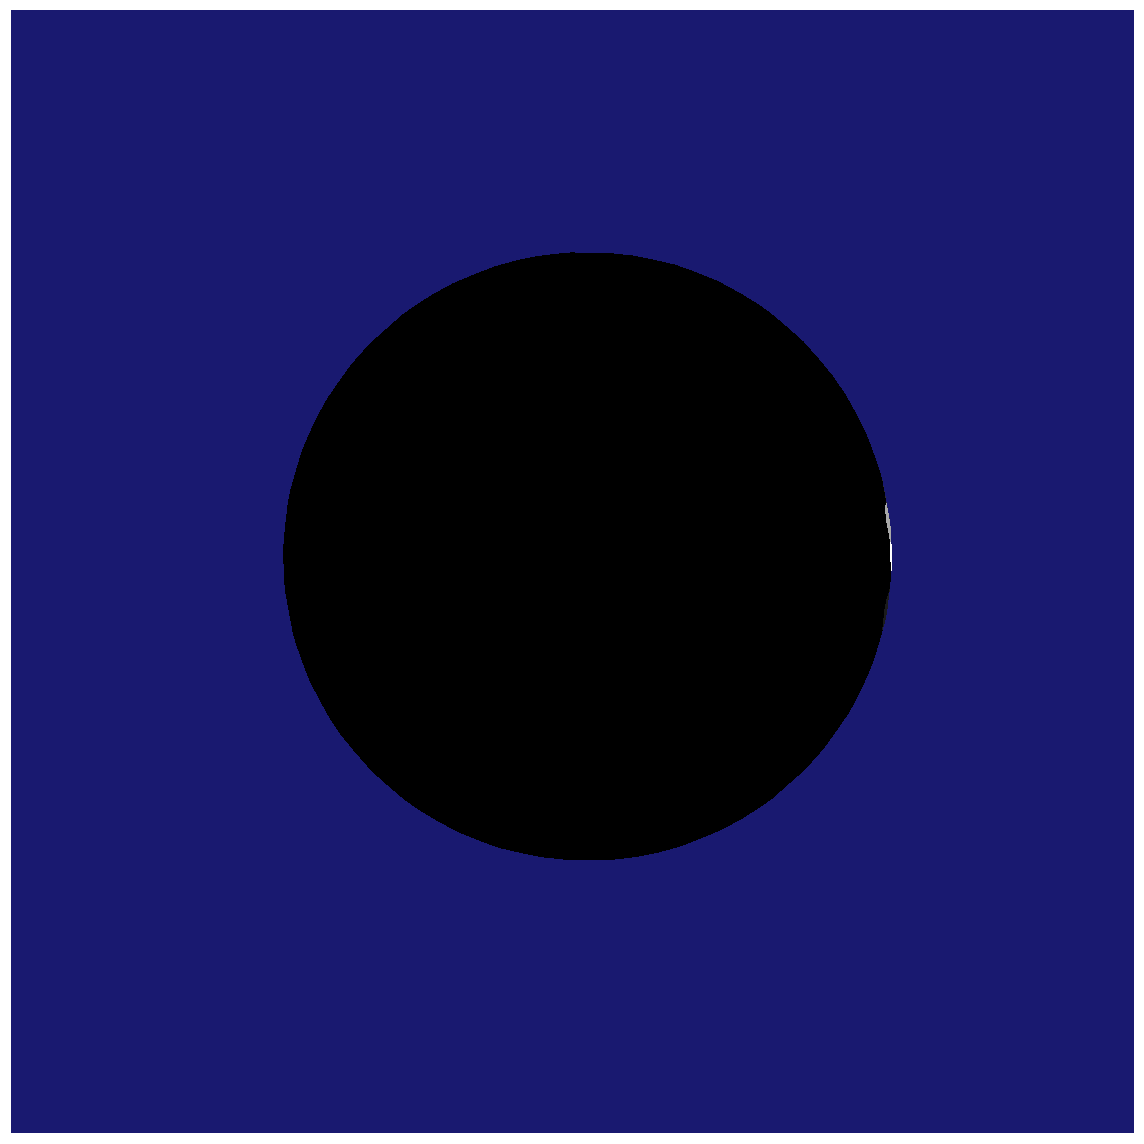

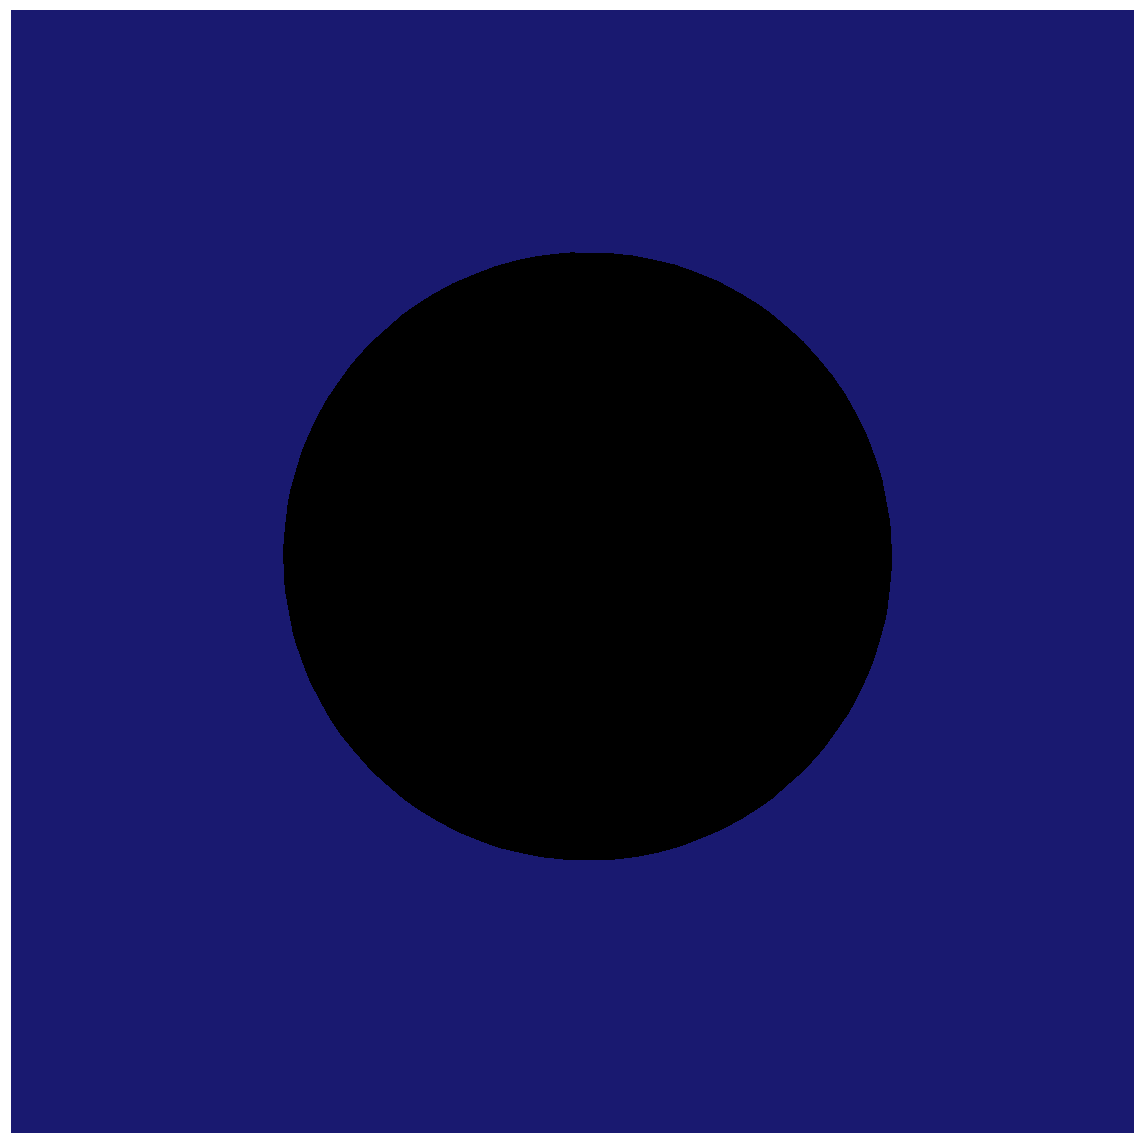

Wall time: 3.77 s


In [3]:
%%time
numpoints = 1001 #resolution of image
model = models[2] #the model that is plotted
gamma = 1*np.pi/2 # pi/2 for edge-on, gamma = 0; face-on

print('The model used is', model)


if model == models[0]: #lambertian
    def f_BRDF(r,s,o):
        return 1/np.pi
    x = np.array([1,0,0])
    I_max = f_BRDF(x,x,x)  #intensity at the middle of the planet for 'full moon'
elif model == models[1]: #lommer seeliger
    def f_BRDF(r,s,o):
        r_s = np.dot(r,s)
        s_o = np.dot(s,o)
        return (1/(4*np.pi))/(r_s+s_o+1e-6)
    I_max = (1/(4*np.pi))/(np.cos(1/3*np.pi)*2+1e-6)

# For specular and water it is calculated later when r and o are known


# albedo_map = np.loadtxt('albedo_map1_n'+str(numpoints)+'.txt',delimiter=',')
voronoi_grid = np.loadtxt('voronoi_grid_n'+str(numpoints),delimiter=',')
facets_vor = np.load('facets_vor_n'+str(numpoints)+'.npy',allow_pickle=',')

phi_grid,theta_grid,area_grid = voronoi_grid.transpose()


# #alternative centers of facets; average of vertices
# for i in range(numpoints):
#     phi_grid[i], theta_grid[i] = cart_to_sph(*np.mean(facets_vor[i],axis=0))




o_vec = np.array([np.sin(gamma),0,np.cos(gamma)]) # planet to observer

# phangles = [np.pi,np.pi+50*np.pi/180,np.pi*1.5,np.pi*1.5+35*np.pi/180]
phangles = [np.pi*(2-0.15),np.pi*(2-0.125),np.pi*(2-0.1),np.pi*(2-0.05),np.pi*(2-0.01)]
for i in range(len(phangles)):
    
    omegat = phangles[i] # angle in the planet's rotation around its star, 0 on x-axis, pi behind star
    r_vec = np.array([-np.cos(omegat),-np.sin(omegat),0]) # planet to star
    
    if model == models[2]:  
        n_vec = (r_vec + o_vec)/np.linalg.norm(r_vec + o_vec)
#         coord_refl = cart_to_sph(*n_vec)
#         coords_grid = np.stack((phi_grid,theta_grid),axis = 1)
#         tree_dist, tree_index = KDTree(coords_grid).query(coord_refl)
        
        std = 2*np.pi*0.01
        def f_BRDF(r,s,o):           
#             n_mean = sph_to_cart(*coords_grid[tree_index]) #normal vector of the mean of the gaussian
            n_mean = n_vec
            central_angle = np.arccos(np.clip(np.dot(s,n_mean),-1,1))
            return 1/(4*r_s*s_o+1e-6)*1/(np.sqrt(2*np.pi)*std)*np.exp(-0.5*(central_angle/std)**2)
            
        I_max = 1/np.cos(0.26*np.pi)**2
    if model == models[3]:  
        n_vec = (r_vec + o_vec)/np.linalg.norm(r_vec + o_vec)
        coord_refl = cart_to_sph(*n_vec)
        coords_grid = np.stack((phi_grid,theta_grid),axis = 1)
        tree_dist, tree_index = KDTree(coords_grid).query(coord_refl)

        std = 2*np.pi*0.01
        def f_BRDF(r,s,o):           
            n_mean = sph_to_cart(*coords_grid[tree_index]) #normal vector of the mean of the gaussian
#             d_lon = min(abs(phi_mean-phi_s),abs(2*np.pi-abs(phi_mean-phi_s))) # difference in longitude (phi) between mean and current point
#             central_angle = np.arccos(np.sin(theta_mean)*np.sin(theta_s)+np.cos(theta_mean)*np.cos(theta_s)*np.cos(d_lon))
            central_angle = np.arccos(np.clip(np.dot(s,n_mean),-1,1))
            return fresnel_s(np.arccos(np.dot(r,s)))*1/(4*r_s*s_o+1e-6)*1/(np.sqrt(2*np.pi)*std)*np.exp(-0.5*(central_angle/std)**2)
            
        I_max = 1/np.cos(0.26*np.pi)**2
    
    # calculate the light intensity at different points
    I = np.zeros(numpoints)

    for i in range(int(numpoints)):
        phi = phi_grid[i]
        theta = theta_grid[i]
        s_vec = np.array([np.cos(phi)*np.sin(theta),
                          np.sin(phi)*np.sin(theta),np.cos(theta)])

        r_s = np.dot(r_vec,s_vec)
        s_o = np.dot(s_vec,o_vec)

        illuminated = positive(r_s)
        visible = positive(s_o)/s_o

        I[i] = illuminated*visible*f_BRDF(r_vec,s_vec,o_vec)
        #area_grid is calculated for a sphere with radius 1, so for small faces, the angles are small, so \Delta\phi*\Delta\theta = area_grid


    #plot
    gray = mpl.cm.get_cmap('gray') #colour scale
    reds = mpl.cm.get_cmap("Reds")

    fig = plt.figure(figsize = [16,16])
    ax = fig.add_subplot(111,projection='3d')
    ax.add_collection3d(a3.art3d.Poly3DCollection(facets_vor,facecolor= gray(I/I_max),antialiased=False))
#     print(I/I_max)
#     if i == 1:
#         norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(I))
#         cmapplot = mpl.cm.ScalarMappable(cmap = gray)
#         cmapplot.set_array([])
#         fig.colorbar(cmapplot, ax=ax, orientation='horizontal',label='$I_{rel}$',shrink=1/2, aspect=40,pad=-0.23)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    ax.elev = 90-gamma*180/np.pi #elev=0, azim=270 for edge-on. elev=90, azim=270 for face-on from above.
    ax.azim = 0
    ax.set_xlabel('y') #the axis in the coordinate system we use
    ax.set_ylabel('x')
    ax.set_zlabel('z')
    ax.axis('off')
    filename = 'planet_illumination/'+ model +'_n'+str(numpoints)+'_gamma'+str(round(gamma*180/np.pi))+'_alpha'+str(round(omegat*180/np.pi))+'.png'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    fig.tight_layout()
    ax.set_facecolor('midnightblue')
#     plt.savefig(filename)
    plt.show()


The model used is LomSee


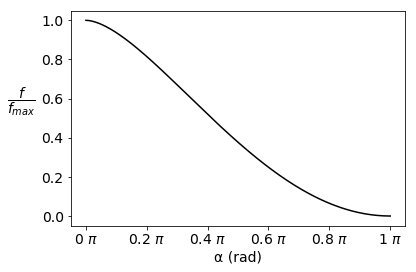

Wall time: 4.54 s


In [42]:
%%time
# light curve of a homogeneous planet
numpoints = 1001
model = models[1] #the model that is plotted
print('The model used is', model)


if model == models[0]: #lambertian
    def f_BRDF(r,s,o):
        return 1/np.pi
elif model == models[1]: #lommer seeliger
    def f_BRDF(r,s,o):
        r_s = np.dot(r,s)
        s_o = np.dot(s,o)
        return (1/(4*np.log(2)))/(r_s+s_o+1e-6)

rho = 6.371e6
R = 1.496e11
alpha = 0/180*np.pi
beta = 0/180*np.pi

day = 24
year = 365*day
omega_day = 2*np.pi/day
omega_year = 2*np.pi/year

voronoi_grid = np.loadtxt('voronoi_grid_n'+str(numpoints),delimiter=',')
facets_vor = np.load('facets_vor_n'+str(numpoints)+'.npy',allow_pickle=',')
phi_grid,theta_grid,area_grid = voronoi_grid.transpose()

res = len(phi_grid)
time_res = 200
time_array = np.linspace(year/2,year,time_res) #a number of time measurements spread evenly throughout a year



albedo_map = np.ones(res)

# observer position
gamma = np.pi/2 # pi/2 for edge-on, gamma = 0 for face-on
o_vec = np.array([np.sin(gamma),0,np.cos(gamma)]) # planet to observer

T = np.zeros((time_res,res))

for i in range(len(time_array)):
    t = time_array[i]
    r_vec = np.array([-np.cos(omega_year*t),-np.sin(omega_year*t),0])
    if model == models[2]:  
        n_vec = (r_vec + o_vec)/np.linalg.norm(r_vec + o_vec)
        coord_refl = cart_to_sph(*n_vec)
        coords_grid = np.stack((phi_grid,theta_grid),axis = 1)
        tree_dist, tree_index = KDTree(coords_grid).query(coord_refl)
        
        std = 2*np.pi*0.01
        def f_BRDF(r,s,o):           
            n_mean = sph_to_cart(*coords_grid[tree_index]) #normal vector of the mean of the gaussian
            central_angle = np.arccos(np.clip(np.dot(s,n_mean),-1,1))
            return 1/(4*r_s*s_o+1e-6*np.sqrt(2*np.pi)*std)*np.exp(-0.5*(central_angle/std)**2)

            
    if model == models[3]:  #water
        n_vec = (r_vec + o_vec)/np.linalg.norm(r_vec + o_vec)
#         coord_refl = cart_to_sph(*n_vec)
#         coords_grid = np.stack((phi_grid,theta_grid),axis = 1)
#         tree_dist, tree_index = KDTree(coords_grid).query(coord_refl)

        std = 2*np.pi*0.01
        def f_BRDF(r,s,o):           
#             n_mean = sph_to_cart(*coords_grid[tree_index]) #normal vector of the mean of the gaussian
            n_mean = n_vec
#             d_lon = min(abs(phi_mean-phi_s),abs(2*np.pi-abs(phi_mean-phi_s))) # difference in longitude (phi) between mean and current point
#             central_angle = np.arccos(np.sin(theta_mean)*np.sin(theta_s)+np.cos(theta_mean)*np.cos(theta_s)*np.cos(d_lon))
            central_angle = np.arccos(np.clip(np.dot(s,n_mean),-1,1))
            if np.isnan(central_angle) and abs(np.dot(s,n_mean)-1)<0.00001:
                central_angle = 0
            return fresnel_s(np.arccos(np.clip(np.dot(r,s),-1,1)))*1/(4*r_s*s_o+1e-6)*1/(np.sqrt(2*np.pi)*std)*np.exp(-0.5*(central_angle/std)**2)
                
    for j in range(res):
        phi = phi_grid[j]
        theta = theta_grid[j]
        s_vec = np.array([np.cos(phi)*np.sin(theta),
                          np.sin(phi)*np.sin(theta),np.cos(theta)])

        r_s = np.dot(r_vec,s_vec)
        s_o = np.dot(s_vec,o_vec)

        illuminated = positive(r_s)
        visible = positive(s_o)

#         f_BRDF, model = 1/np.pi, 'lambert' #lambertian
#         f_BRDF, model = (1/(4*np.pi))/(r_s+s_o+1e-6), 'LomSee' # Lommel-seeliger
        
        T[i][j] = illuminated*visible*np.sin(theta)*area_grid[j] * f_BRDF(r_vec,s_vec,o_vec)
#     print(i)
        #area_grid is calculated for a sphere with radius 1, so for small faces, the angles are small, so \Delta\phi*\Delta\theta = area_grid
f_curve = np.matmul(T,albedo_map)
mpl.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_array/year*2-1,f_curve/np.amax(f_curve),c='black')
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g $\pi$'))
# ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
ax.set_xlabel('α (rad)')
ax.set_ylabel('$\dfrac{f}{f_{max}}$',rotation=0,labelpad = 20)
filename = 'planet_illumination/'+ model +'1_phasecurve_n'+str(numpoints)+'.png'
fig.tight_layout()
plt.savefig(filename,bbox_inches='tight',dpi=100)
plt.show()

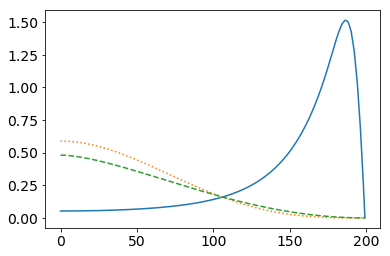

In [47]:
f_loms = copy.copy(f_curve)
plt.plot(f_fresnel/0.015)
plt.plot(f_lamb,linestyle='dotted')
plt.plot(f_loms,linestyle='--')

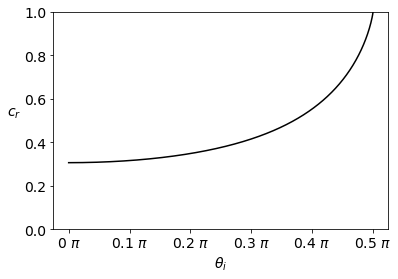

Wall time: 1.31 s


In [4]:
%%time
# lommel seeliger normalisation

mpl.rcParams.update({'font.size': 14})
i = np.linspace(0,np.pi/2,1000)
lomseenorm = 0.5-0.5*np.cos(i)*np.log((1+np.cos(i))/np.cos(i))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(i/np.pi,lomseenorm/max(lomseenorm),c='black')
ax.set_xlabel('$θ_i$')
ax.set_ylabel('$c_r$',rotation=0,labelpad = 10)
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
ax.set_ylim(0,1)
filename = 'norms/lomsee.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
plt.savefig(filename,bbox_inches='tight',dpi=100)
plt.show()

In [29]:
print(np.mean(lomseenorm))

0.2207422307218346


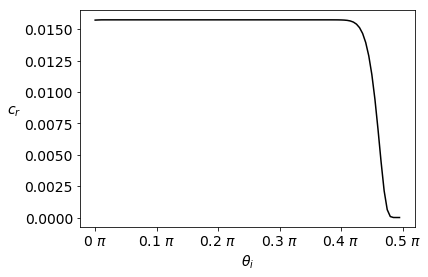

Wall time: 49.8 s


In [5]:
%%time
# specular model normalisation met s op [0,0,1]
m=1000

i_ang = np.linspace(0,np.pi/2*0.99,100)
integrals = np.zeros(len(i_ang))
num = 0
for i in i_ang:
    psi = np.linspace(0,2*np.pi*(1-1/m),m-1) + 2*np.pi/m   #midpoints for integral
    e = np.linspace(0,np.pi/2*(1-1/m),m) + np.pi/2*1/m     #      ''
    dpsi = psi[1]-psi[0]
    de = e[1]-e[0]
    psi, e = np.meshgrid(psi,e)
    
    s = np.array([np.zeros((m,m-1)),np.zeros((m,m-1)),np.ones((m,m-1))])
    r = np.array([np.ones((m,m-1))*np.sin(i),np.zeros((m,m-1)),np.ones((m,m-1))*np.cos(i)])
    o = np.array([np.cos(psi)*np.sin(e),np.sin(psi)*np.sin(e),np.cos(e)])
    n = (o+r)/np.linalg.norm(o+r,axis=0)
    central_angle = np.arccos(np.clip(np.sum(n*s,axis=0),-1,1))
    
    std=2*np.pi/1000
    integrals[num] = 1/(4*np.sqrt(2*np.pi)*std*np.cos(i))*np.sum(np.sin(e)*np.exp(-0.5*(central_angle/std)**2)*dpsi*de)
#     integrals[num] = 1/(4*np.pi)*np.sum(np.sin(e)*np.cos(e)/(np.cos(i)+np.cos(e))*dpsi*de)    # lommel-seeliger
    num+=1
mpl.rcParams.update({'font.size': 14})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(i_ang/np.pi,integrals,c='black')

ax.set_xlabel('$θ_i$')
ax.set_ylabel('$c_r$',rotation=0,labelpad = 10)
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
# ax.set_ylim(0,1)
filename = 'norms/spec.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
# plt.savefig(filename,bbox_inches='tight',dpi=100)
plt.show()

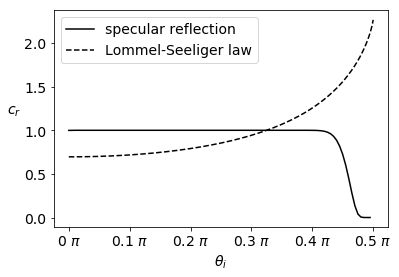

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(i_ang/np.pi,integrals/max(integrals),c='black',label = 'specular reflection')
ax.plot(np.linspace(0,np.pi/2,1000)/np.pi,lomseenorm/np.log(2)*np.pi,c='black',linestyle='--',label = 'Lommel-Seeliger law')
ax.legend(loc='upper left')

ax.set_xlabel('$θ_i$')
ax.set_ylabel('$c_r$',rotation=0,labelpad = 10)
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
# ax.set_xlim(-0.01,.49)
# ax.set_ylim(-.05,1.05)
filename = 'norms/norms.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
plt.savefig(filename,bbox_inches='tight',dpi=100)
plt.show()


In [25]:
%%time
# sum the light recieved over all viewing angles to check if incident = transmitted
# this is done by taking a viewing angle and seeing the light as if it is transmitted to the voronoi facet corresponding to the observer's position
res = 101
voronoi_grid = np.loadtxt('voronoi_grid_n'+str(res),delimiter=',')
facets_vor = np.load('facets_vor_n'+str(res)+'.npy',allow_pickle=',')
phi_grid, theta_grid, area_grid = voronoi_grid.transpose()

int_res = 101
int_voronoi_grid = np.loadtxt('voronoi_grid_n'+str(int_res),delimiter=',')
int_phi_grid, int_theta_grid, int_area_grid = int_voronoi_grid.transpose()

r_vec = np.array([-np.cos(0.5*np.pi),-np.sin(0.5*np.pi),0])
albedo_map = np.ones(res)

T = np.zeros((int_res,res))

for i in range(int_res):
    o_vec = sph_to_cart(int_phi_grid[i],int_theta_grid[i])

    for j in range(res):
        phi = phi_grid[j]
        theta = theta_grid[j]
        s_vec = sph_to_cart(phi,theta)

        r_s = np.dot(r_vec,s_vec)
        s_o = np.dot(s_vec,o_vec)

        illuminated = positive(r_s)
        visible = positive(s_o)

        T[i][j] = illuminated*visible*np.sin(theta)*area_grid[j]

f = np.sin(int_theta_grid)*int_area_grid*np.matmul(T,albedo_map)/(4*np.pi**2)
print(np.sum(f))

0.17218371014441447
Wall time: 389 ms


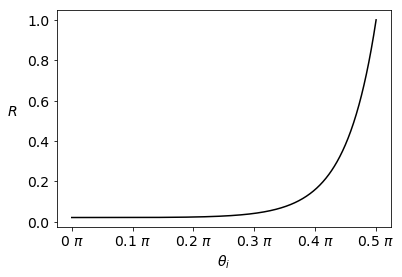

In [7]:
mpl.rcParams.update({'font.size': 14})
hoek = np.linspace(0,np.pi/2,1000)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(hoek/np.pi,(fresnel_s(hoek)+fresnel_p(hoek))/2,c='black')
plt.xlabel('$θ_i$')
plt.ylabel('$R$',rotation=0,labelpad=15)
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g $\pi$'))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
plt.savefig('Fresnel.png',dpi=100,bbox_inches='tight')
plt.show()